In [1]:
!pip -q install moabb

In [2]:
from moabb.datasets import BI2013a
import torch
import mne, logging
mne.set_log_level("WARNING")
logging.getLogger("mne").setLevel(logging.WARNING)
import numpy as np
from pathlib import Path

In [3]:
from abc import ABC, abstractmethod
import torch

class BaseModel(ABC):
    def __init__(self, learning_rate: float, max_epochs: int, device: str):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.weights = None
        self.bias = None
        self.device = device
        self.history = {'train_loss': [], 'train_metrics': [], 'val_metrics': []}

    @abstractmethod
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        pass

    @abstractmethod
    def predict(self, X: torch.Tensor):
        pass

    @abstractmethod
    def score(self, X: torch.Tensor, y: torch.Tensor):
        pass

In [4]:
class ClassificationMetrics:
    @staticmethod
    def hinge_loss(y_pm1: torch.Tensor, scores: torch.Tensor) -> torch.Tensor:
        """
        Средний hinge-loss без регуляризации:
        mean(max(0, 1 - y * score)), где y ∈ {-1, +1}, score = X@w + b
        """
        y_pm1 = y_pm1.view(-1).float()
        scores = scores.view(-1).float()
        return torch.clamp(1.0 - y_pm1 * scores, min=0.0).mean()

    @staticmethod
    def accuracy(y_true01: torch.Tensor, y_pred01: torch.Tensor) -> torch.Tensor:
        """
        Доля совпадений предсказаний с истинными метками (оба тензора {0,1})
        """
        y_true01 = y_true01.view(-1).float()
        y_pred01 = y_pred01.view(-1).float()
        return (y_true01 == y_pred01).float().mean()

    @staticmethod
    def f1(y_true01: torch.Tensor, y_pred01: torch.Tensor) -> torch.Tensor:
        """
        F1 по TP/FP/FN, рассчитанным из {0,1}
        """
        y = y_true01.view(-1).bool()
        p = y_pred01.view(-1).bool()
        tp = (y & p).sum().float()
        fp = (~y & p).sum().float()
        fn = (y & ~p).sum().float()
        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        return 2 * precision * recall / (precision + recall + 1e-12)

In [5]:
class SVM(BaseModel):
    def __init__(self, learning_rate=1e-3, max_epochs=100, batch_size=1024, C=1.0, device='cpu'):
        super().__init__(learning_rate, max_epochs, device)
        self.batch_size = int(batch_size)
        self.C = float(C)
        self.threshold = 0.0

    def _hinge_loss(self, X, y_pm1):
        scores = X @ self.weights + self.bias
        hinge_mean = ClassificationMetrics.hinge_loss(y_pm1, scores)
        reg = 0.5 * torch.sum(self.weights ** 2)
        return reg + self.C * hinge_mean

    def fit(self, X, y01, X_val=None, y_val=None):
        N, D = X.shape
        if self.weights is None or self.bias is None:
            self.weights = torch.zeros(D, device=self.device)
            self.bias = torch.zeros(1, device=self.device)

        X = X.to(self.device).float()
        y_pm1 = torch.where(y01 == 0, -1.0, 1.0).to(self.device).float()

        for epoch in range(self.max_epochs):
            perm = torch.randperm(N, device=self.device)
            total_loss = 0.0

            for i in range(0, N, self.batch_size):
                idx = perm[i:i + self.batch_size]
                Xb, yb = X[idx], y_pm1[idx]

                scores = Xb @ self.weights + self.bias
                margins = 1.0 - yb * scores
                mask = margins > 0

                B = max(1, Xb.shape[0])
                grad_w = self.weights - self.C * (Xb[mask].T @ yb[mask]) / B
                grad_b = - self.C * yb[mask].sum() / B

                self.weights -= self.learning_rate * grad_w
                self.bias    -= self.learning_rate * grad_b

                total_loss += self._hinge_loss(Xb, yb).item()

            avg_loss = total_loss / max(1, (N + self.batch_size - 1) // self.batch_size)
            self.history['train_loss'].append(avg_loss)

            train_metrics = self.score(X, y01)
            self.history['train_metrics'].append(train_metrics)

            val_metrics = None
            if X_val is not None and y_val is not None:
                val_metrics = self.score(X_val, y_val)
                self.history['val_metrics'].append(val_metrics)

            if (epoch % 10 == 0) or (epoch == self.max_epochs - 1):
                msg = (
                    f"Epoch {epoch+1}/{self.max_epochs} | "
                    f"loss={avg_loss:.4f} | "
                    f"train acc={float(train_metrics['accuracy']):.4f} "
                    f"f1={float(train_metrics['f1_score']):.4f}"
                )
                if val_metrics is not None:
                    msg += (
                        f" | val acc={float(val_metrics['accuracy']):.4f} "
                        f"f1={float(val_metrics['f1_score']):.4f}"
                    )
                print(msg)

    def decision_function(self, X):
        X = X.to(self.device).float()
        return X @ self.weights + self.bias

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores > self.threshold).float()

    def score(self, X, y01):
        X = X.to(self.device).float()
        y01 = y01.to(self.device).float()
        scores = self.decision_function(X)
        y_pred = (scores > self.threshold).float()
        y_pm1  = torch.where(y01 == 0, -1.0, 1.0)
        hinge = ClassificationMetrics.hinge_loss(y_pm1, scores)
        acc   = ClassificationMetrics.accuracy(y01, y_pred)
        f1    = ClassificationMetrics.f1(y01, y_pred)
        return {"hinge_loss": hinge, "accuracy": acc, "f1_score": f1}


In [6]:
def infer_target_ids(event_id: dict):
    lower = {k.lower(): v for k, v in event_id.items()}
    t = [k for k in lower if "target" in k and "non" not in k]
    n = [k for k in lower if "non" in k and "target" in k]
    if t and n:
        return lower[t[0]], lower[n[0]]
    vals = sorted(set(event_id.values()))
    if len(vals) >= 2:
        return vals[-1], vals[0]
    raise RuntimeError(f"Cannot infer target/non-target from {event_id}")

def preprocess_raw(raw: mne.io.BaseRaw, l_freq=1.0, h_freq=20.0, sfreq=128):
    raw = raw.copy().load_data()
    raw.pick_types(eeg=True, eog=False)
    raw.filter(l_freq, h_freq, verbose=False)
    raw.set_eeg_reference("average", projection=False, verbose=False)
    raw.resample(sfreq, verbose=False)
    return raw

def epoch_and_features(raw: mne.io.BaseRaw, tmin=-0.2, tmax=0.8, baseline=(None, 0), decim=2):
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    tgt, non = infer_target_ids(event_id)
    epochs = mne.Epochs(raw, events, event_id={"Target": tgt, "NonTarget": non},
                        tmin=tmin, tmax=tmax, baseline=baseline, preload=True, verbose=False)
    X = epochs.get_data()[:, :, ::decim]               # (trials, ch, time//decim)
    y = (epochs.events[:, 2] == tgt).astype(np.float32)  # {0,1}
    X = X.reshape(X.shape[0], -1).astype("float32")    # (trials, ch*time)
    return X, y

def collect_subjects(ds: BI2013a, subject_ids):
    Xs, ys = [], []
    nested = ds.get_data(subject_ids)  # {subj: {session: {run: Raw}}}
    for sessions in nested.values():
        for runs in sessions.values():
            for raw in runs.values():
                raw_p = preprocess_raw(raw)
                X, y = epoch_and_features(raw_p)
                if len(y) > 0:
                    Xs.append(X); ys.append(y)
    X = np.vstack(Xs).astype(np.float32)
    y = np.hstack(ys).astype(np.float32)
    return X, y

def fit_standardizer(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-8
    return mu, sd

def transform_standardizer(X, mu, sd):
    return (X - mu) / sd

def stratified_split(X, y, val_frac=0.15, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    nvp = max(1, int(len(pos) * val_frac))
    nvn = max(1, int(len(neg) * val_frac))
    val_idx = np.concatenate([
        rng.choice(pos, size=min(nvp, len(pos)), replace=False),
        rng.choice(neg, size=min(nvn, len(neg)), replace=False)
    ])
    mask = np.ones(len(y), dtype=bool)
    mask[val_idx] = False
    tr_idx = np.where(mask)[0]
    return (X[tr_idx], y[tr_idx]), (X[val_idx], y[val_idx])

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# 4 субъекта: [1,2,3,4]
ds = BI2013a(NonAdaptive=True, Adaptive=True, Training=True, Online=True)
train_subjects = [1, 2, 3]
test_subjects  = [4]
print(f"Subjects → train={train_subjects}, test={test_subjects}")

print("Collect TRAIN subjects...")
X_tr_all, y_tr_all = collect_subjects(ds, train_subjects)
print("Collect TEST subject...")
X_test, y_test = collect_subjects(ds, test_subjects)

Subjects → train=[1, 2, 3], test=[4]
Collect TRAIN subjects...
Collect TEST subject...


In [9]:
(X_train, y_train), (X_val, y_val) = stratified_split(X_tr_all, y_tr_all, val_frac=0.15, rng=np.random.default_rng(42))
print(f"Shapes: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

Shapes: train=(28703, 1040), val=(5065, 1040), test=(11544, 1040)


In [10]:
mu, sd = fit_standardizer(X_train)
X_train = transform_standardizer(X_train, mu, sd)
X_val   = transform_standardizer(X_val,   mu, sd)
X_test  = transform_standardizer(X_test,  mu, sd)

X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)
y_val_t   = torch.from_numpy(y_val).to(device)
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

In [11]:
# Модель и обучение
svm = SVM(learning_rate=1e-3, max_epochs=40, batch_size=2048, C=1.0, device=device)
svm.fit(X_train_t, y_train_t, X_val_t, y_val_t)

Epoch 1/40 | loss=0.9828 | train acc=0.6444 f1=0.3572 | val acc=0.6432 f1=0.3590
Epoch 11/40 | loss=0.8502 | train acc=0.7187 f1=0.4178 | val acc=0.7159 f1=0.4153
Epoch 21/40 | loss=0.7524 | train acc=0.7665 f1=0.4599 | val acc=0.7603 f1=0.4522
Epoch 31/40 | loss=0.6818 | train acc=0.8031 f1=0.4898 | val acc=0.8006 f1=0.4883
Epoch 40/40 | loss=0.6279 | train acc=0.8336 f1=0.5128 | val acc=0.8322 f1=0.5087


In [12]:
# Метрики
print("VAL metrics:", {k: float(v) for k, v in svm.history["val_metrics"][-1].items()})
test_metrics = svm.score(X_test_t, y_test_t)
print("TEST metrics:", {k: float(v) for k, v in test_metrics.items()})

VAL metrics: {'hinge_loss': 0.6122469305992126, 'accuracy': 0.8321816325187683, 'f1_score': 0.5086705088615417}
TEST metrics: {'hinge_loss': 0.6547540426254272, 'accuracy': 0.8350658416748047, 'f1_score': 0.1345454603433609}


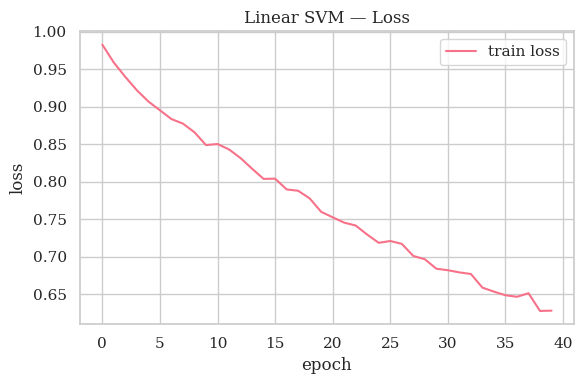

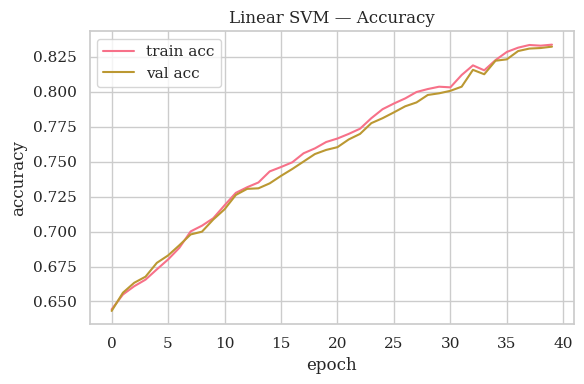

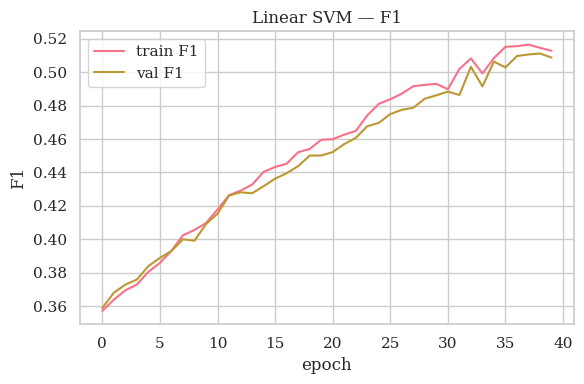

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(svm.history["train_loss"], label="train loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Linear SVM — Loss")
plt.legend(); plt.tight_layout(); plt.show()

tr_acc = [float(m["accuracy"]) for m in svm.history["train_metrics"]]
va_acc = [float(m["accuracy"]) for m in svm.history["val_metrics"]]
plt.figure(figsize=(6,4))
plt.plot(tr_acc, label="train acc")
plt.plot(va_acc, label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Linear SVM — Accuracy")
plt.legend(); plt.tight_layout(); plt.show()

tr_f1 = [float(m["f1_score"]) for m in svm.history["train_metrics"]]
va_f1 = [float(m["f1_score"]) for m in svm.history["val_metrics"]]
plt.figure(figsize=(6,4))
plt.plot(tr_f1, label="train F1")
plt.plot(va_f1, label="val F1")
plt.xlabel("epoch"); plt.ylabel("F1"); plt.title("Linear SVM — F1")
plt.legend(); plt.tight_layout(); plt.show()